In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML

In [2]:
# np.random.seed(42)

# Gaussian Mixture Model

In [3]:
def gaussian_mixture(pis, mus, sigmas, N: int = 1000):
    assert len(pis)==len(mus)==len(sigmas), "K is not the same for pis, mus, sigmas"
    assert np.abs(1-pis.sum())<1.e-3, "probabilities weigths should sum to 1"
    K = pis.shape[0]
    pi_k = np.random.choice(K, p=pis, size=N)
    p_x = [np.random.multivariate_normal(mean=mus[i], cov=sigmas[i]) for i in pi_k]
    p_x = np.array(p_x)

    return p_x, pi_k

In [4]:
mus = np.array([[0.2, 4.3], [1.5, 2.3], [-2.8, -1.8], [-2.8, 2.8], [3.8, 1.1]])
sigmas = [
    np.diag([0.1,0.2]),
    np.diag([0.3,0.5]),
    np.diag([0.7,0.11]),
    np.diag([0.13,0.17]),
    np.diag([0.19,0.23]),
]

rotation_mat = lambda x: np.array([[np.cos(x), -np.sin(x)],[np.sin(x), np.cos(x)]])

rotations = [rotation_mat(x) for x in np.random.random(len(sigmas))]
rotated_sigmas = [R@S@R.T for (R,S) in zip(rotations, sigmas)]

pis = np.random.dirichlet(np.ones(mus.shape[0]))

pis.sum()

0.9999999999999999

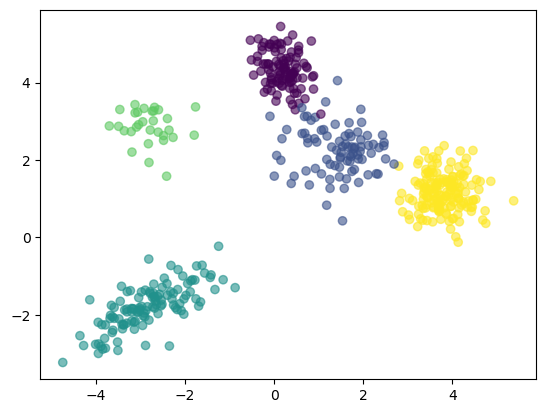

In [5]:
N = 500
data, labels = gaussian_mixture(pis,mus,rotated_sigmas,N=N)
plt.scatter(data[:,0], data[:,1], c=labels, alpha=0.6)

<Axes: ylabel='Density'>

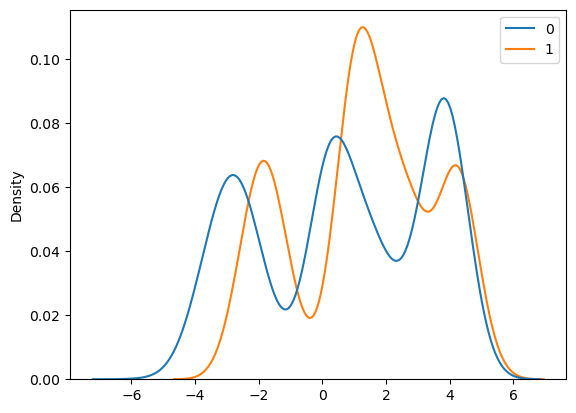

In [6]:
data, labels = gaussian_mixture(pis,mus,rotated_sigmas,N=2000)
sns.kdeplot(data)

# EM algorithm

In [7]:
def em_algorithm(K: int, X: np.ndarray, save_dir: str, eps_log: float = 1e-6, eps_conv: float = 1e-4, interval: int = 200):
    N = X.shape[0]
    ndim = X.shape[1]

    sigma_square = X.var()

    ELBO_old = - np.inf

    # Sample random values mu_1,mu_K from x1,...,xN
    mus = np.array([X[i] for i in np.random.randint(0, len(X), K)])

    sigmas = sigma_square * np.identity(ndim)
    sigmas = sigmas[np.newaxis,:].repeat(K, axis=0) / K

    params = []

    pis = np.ones(K) / K

    R = np.zeros((N,K))

    num_iter = 0

    while True:

        ELBO_new = 0

        # E step
        for i in range(N):
            xi = X[i]

            raw_p = np.zeros(K)

            for k in range(K):
                sigma_k = sigmas[k]
                mu_k = mus[k]
                # r_ik = p(zi = k|xi , \theta_t)
                # we use log trick here
                p_xi_k = -0.5 * (xi-mu_k).T @ np.linalg.inv(sigma_k) @ (xi-mu_k)
                p_xi_k -= 0.5 * np.log(np.linalg.det(sigma_k)+eps_log)
                p_xi_k -= 0.5 * ndim * np.log(2*np.pi + eps_log)

                r_ik = p_xi_k + np.log(pis[k]+eps_log)
                R[i,k] = r_ik

                raw_p[k] = r_ik
                # ELBO_new  = \sum_i \sum_k R[i,k] [log pis[k] + log p(xi|zi=k,\theta) - log R[i,k]]

            # max trick
            max_log = np.max(R[i,:])
            # exp-sum trick
            R[i,:] = np.exp(R[i,:] - max_log)
            R[i,:] /= R[i,:].sum()
            
            # compute ELBO
            ELBO_new += np.sum(R[i,:] * (raw_p - np.log(R[i,:] + eps_log)))

        # M step
        pis = R.sum(axis=0) / N
        mus = np.matmul(R.T, X) / R.sum(axis=0)[:,np.newaxis]

        for k in range(K):
            r_ik = R[:,k]
            r_k = r_ik.sum()
            pis[k] = r_k / N

            mus[k] = (r_ik[:, np.newaxis] * X).sum(axis=0) / r_k

            sigma_k = np.zeros((ndim,ndim))
            for i in range(N):
                diff = X[i] - mus[k]
                sigma_k += r_ik[i] * np.outer(diff, diff)
            sigma_k /= r_k

            sigmas[k] = sigma_k

        if np.abs(ELBO_new - ELBO_old) < eps_conv:
            break

        params.append((pis,mus,sigmas))

        ELBO_old = ELBO_new
        num_iter += 1

    fig, ax = plt.subplots()
    os.makedirs(save_dir, exist_ok=True)

    def init():
      sns.kdeplot(X[:,0], color="black", linestyle="--", ax=ax)
      sns.kdeplot(X[:,1], color="green", linestyle="--", ax=ax)

    def update_pdf(frame):
        ax.clear()
        init()
        temp_pis, temp_mus, temp_sigmas = params[frame]
        new_data, labels = gaussian_mixture(temp_pis,temp_mus,temp_sigmas)
        sns.kdeplot(new_data[:,1], color="b", ax=ax)
        sns.kdeplot(new_data[:,0], color="r", ax=ax)
        ax.legend(["true-pdf-0", "true-pdf-1", "est-pdf-0", "est-pdf-1"])
        ax.set_title(f"Iterations: {frame}")
        fig.savefig(os.path.join(save_dir, f"{frame}.png"))

    anim = animation.FuncAnimation(fig, update_pdf, frames=len(params), interval=interval)
    plt.close()

    print("Number of iterations:", num_iter)
    print("ELBO:", ELBO_new)
    return (pis, mus, sigmas), R, ELBO_new, anim


In [8]:
!rm -rf em*

In [9]:
def test(K, X, eps_conv, interval=200):
    estimated_theta, probs, _, anim = em_algorithm(K=K, X=X, eps_conv=eps_conv, interval=interval, save_dir=f"em-K{K}")
    clusters = probs.argmax(axis=1)
    anim.save(f"em-K{K}.gif",writer='pillow')
    plt.title(f"culsters: K={K}")
    plt.scatter(data[:,0], data[:,1], c=clusters, alpha=0.6)
    plt.show()
    plt.close()
    return HTML(anim.to_html5_video())

Number of iterations: 6
ELBO: -7117.62702864055


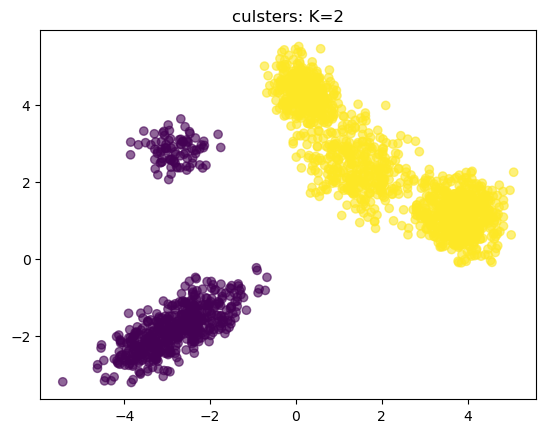

In [10]:
test(K=2, X=data, eps_conv=1e-3, interval=200)

Number of iterations: 26
ELBO: -6411.4403324649775


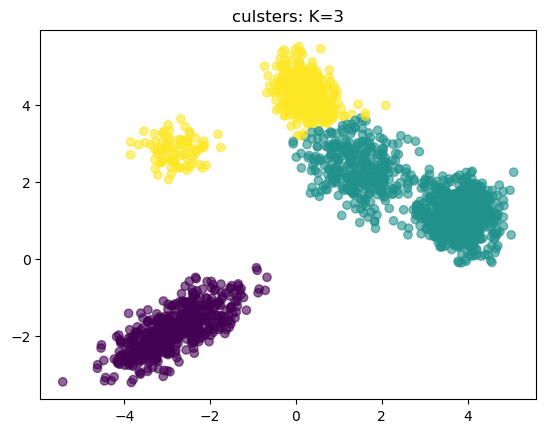

In [11]:
test(K=3, X=data, eps_conv=1e-3, interval=200)

Number of iterations: 14
ELBO: -5813.370310010942


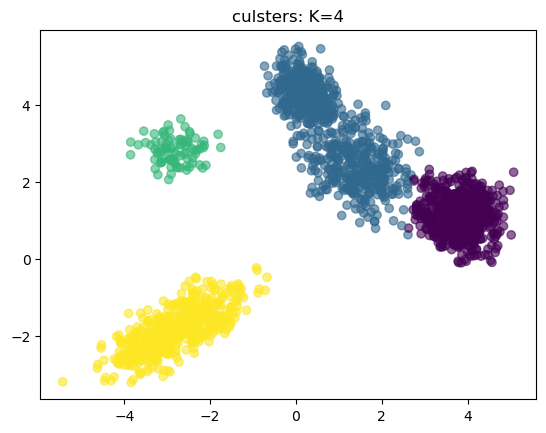

In [12]:
test(K=4, X=data, eps_conv=1e-3, interval=200)

Number of iterations: 263
ELBO: -6281.207115890847


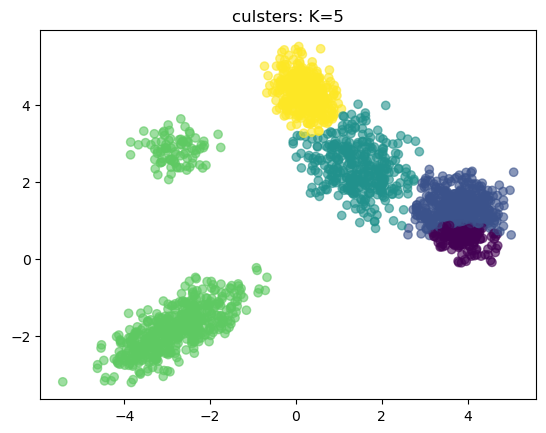

In [13]:
test(K=5, X=data, eps_conv=1e-3, interval=200)

Number of iterations: 24
ELBO: -5613.521627257007


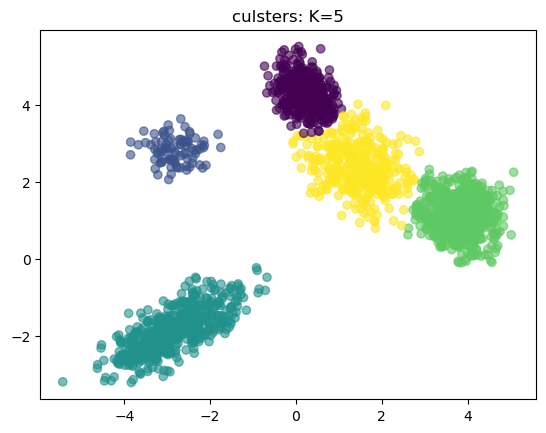

In [18]:
test(K=5, X=data, eps_conv=1e-3, interval=200)

# EM algorithm: stochastic version

In [15]:
# def test_stoch(K, X, eps_conv=1e-1, interval=200):
#     estimated_theta, probs, _, anim = em_algorithm_stoch(K=K, X=X, eps_conv=eps_conv, interval=interval, save_dir=f"em-K{K}")
#     clusters = probs.argmax(axis=1)
#     anim.save(f"em-K{K}.gif",writer='pillow')
#     plt.scatter(data[:,0], data[:,1], c=clusters, alpha=0.6)
#     plt.show()
#     plt.close()
#     return HTML(anim.to_html5_video())

In [16]:
# test_stoch(K=2, X=data, eps_conv=1e-3, interval=200)